# A Machine Learning Driven Analysis of Private Equity Funding in Seed-Stage Healthcare Startups

---
## Colab Setup

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive

drive.mount('/content/drive')

# Folder to mount
FOLDERNAME = 'gene225/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Ensure the Python interpreter of the Colab VM can load python files
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# cd into the dataset
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/gene225/project


In [2]:
# Configure module re-loader
%load_ext autoreload
%autoreload 2

In [3]:
# Imports
!pip install shap
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---
## Crunchbase Dataset

In [4]:
raw_dataset = pd.read_csv('./data/crunchbase_original.csv')

In [5]:
def list_to_one_hot(df, col_name):
  group_df = df[col_name].str.get_dummies(sep=',')
  group_df.columns = [col_name + ' ' + col for col in group_df.columns]
  group_df = group_df.astype('float')
  df = pd.concat([df, group_df], axis=1)
  df = df.drop(columns=[col_name])
  return df

def str_to_one_hot(df, col_name, fill_nans, fill_val):
  if fill_nans is True:
    df[col_name] = df[col_name].fillna(fill_val)
  group_df = pd.get_dummies(df[col_name])
  group_df.columns = [col_name + ' ' + col for col in group_df.columns]
  group_df = group_df.astype('float')
  df = pd.concat([df, group_df], axis=1)
  df = df.drop(columns=[col_name])
  return df

def str_to_float(df, col_name, fill_nans, fill_val):
  df[col_name] = df[col_name].replace(',', '', regex=True)
  df[col_name] = df[col_name].astype('float')
  if fill_nans is True:
    if fill_val == 'mean':
      df[col_name] = df[col_name].fillna((df[col_name].mean()))
    else:
      df[col_name] = df[col_name].fillna(fill_val)
  return df

def growth_to_float(df, col_name):
  df[col_name] = df[col_name].astype('str')
  df[col_name] = df[col_name].replace('%', '', regex=True)
  return df

def datetime_encoding(df, col_date1, col_date2, new_col):
  df[col_date1] = pd.to_datetime(df[col_date1])
  df[col_date1] = df[col_date1].fillna((df[col_date1].mean()))
  df[col_date2] = pd.to_datetime(df[col_date2])
  df[col_date2] = df[col_date2].fillna((df[col_date2].mean()))
  df[new_col] = df[col_date2] - df[col_date1]
  df[new_col] = df[new_col].dt.days / 365
  df = df.drop(columns=[col_date1, col_date2])
  return df


def preprocess_dataset(dataset):
  # Create copy
  new_dataset = dataset.copy()
  # Drop unnecesary columns
  drop_cols = ['Organization Name', 'Organization Name URL', 'IPO Status', 'Last Funding Type', 'Founded Date Precision', 'Last Leadership Hiring Date', 'Contact Job Departments',
               'Description', 'Funding Status', 'Valuation at IPO', 'Valuation at IPO Currency', 'Valuation at IPO Currency (in USD)', 'Headquarters Regions', 'Operating Status',
               'Exit Date', 'Exit Date Precision', 'Closed Date', 'Closed Date Precision', 'Website', 'Twitter', 'LinkedIn', 'Facebook', 'Contact Email', 'Phone Number', 'Hub Tags',
               'Full Description', 'Actively Hiring', 'Investor Type', 'Investment Stage', 'Number of Portfolio Organizations', 'Number of Investments', 'Number of Lead Investments',
               'Number of Diversity Investments', 'Number of Exits', 'Number of Exits (IPO)', 'Accelerator Duration (in weeks)', 'Accelerator Application Deadline',
               'Accelerator Program Type', 'School Type', 'School Program', 'Number of Enrollments', 'School Method', 'Number of Founders (Alumni)', 'Number of Alumni', 'Founders', 
               'Last Funding Amount', 'Last Funding Amount Currency', 'Last Funding Amount Currency (in USD)', 'Last Equity Funding Amount', 'Last Equity Funding Amount Currency',
               'Last Equity Funding Amount Currency (in USD)', 'Last Equity Funding Type', 'Total Equity Funding Amount', 'Total Equity Funding Amount Currency',
               'Total Equity Funding Amount Currency (in USD)', 'Total Funding Amount', 'Total Funding Amount Currency', 'Top 5 Investors', 'Number of Acquisitions',
               'Acquisition Status', 'Transaction Name', 'Transaction Name URL', 'Acquired by', 'Acquired by URL', 'Price', 'Price Currency', 'Price Currency (in USD)',
               'Announced Date', 'Announced Date Precision', 'Acquisition Type', 'Acquisition Terms', 'IPO Date', 'Delisted Date', 'Delisted Date Precision', 'Money Raised at IPO',
               'Money Raised at IPO Currency', 'Money Raised at IPO Currency (in USD)', 'Stock Symbol', 'Stock Symbol URL', 'Stock Exchange', 'Last Layoff Mention Date',
               'CB Rank (School)', 'Number of Private Contacts', 'IPqwery - Most Popular Patent Class', 'IPqwery - Most Popular Trademark Class', 'Aberdeen - IT Spend',
               'Aberdeen - IT Spend Currency', 'Aberdeen - IT Spend Currency (in USD)', 'Number of Private Notes', 'Tags', 'Industries', 'CB Rank (Company)', 'CB Rank (Organization)']
  new_dataset = new_dataset.drop(columns=drop_cols)
  # Datetime encoding
  new_dataset = datetime_encoding(new_dataset, 'Founded Date', 'Last Funding Date', 'Company Age (Years)')
  # String to one-hot
  new_dataset['Headquarters Location'] = new_dataset['Headquarters Location'].apply(lambda location: location.split(', ')[1])
  new_dataset = str_to_one_hot(new_dataset, 'Headquarters Location', False, None)
  new_dataset = str_to_one_hot(new_dataset, 'Estimated Revenue Range', False, None)
  new_dataset = str_to_one_hot(new_dataset, 'Company Type', True, 'Non Profit')
  # List to one-hot
  new_dataset = list_to_one_hot(new_dataset, 'Industry Groups')
  new_dataset = list_to_one_hot(new_dataset, 'Diversity Spotlight (US Only)')
  new_dataset = list_to_one_hot(new_dataset, 'Number of Employees')
  # String to float
  # new_dataset = str_to_float(new_dataset, 'CB Rank (Company)', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'Number of Articles', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Number of Founders', True, 1.0)
  new_dataset = str_to_float(new_dataset, 'Number of Funding Rounds', True, 1.0)
  new_dataset = str_to_float(new_dataset, 'Total Funding Amount Currency (in USD)', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Number of Lead Investors', True, 1.0)
  new_dataset = str_to_float(new_dataset, 'Number of Investors', True, 1.0)
  new_dataset = str_to_float(new_dataset, 'Number of Events', True, 0.0)
  # new_dataset = str_to_float(new_dataset, 'CB Rank (Organization)', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'Trend Score (7 Days)', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Trend Score (30 Days)', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Trend Score (90 Days)', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Similar Companies', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Number of Contacts', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'SEMrush - Monthly Visits', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Average Visits (6 months)', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Visit Duration', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Page Views / Visit', True, 'mean')
  
  new_dataset = str_to_float(new_dataset, 'SEMrush - Global Traffic Rank', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Monthly Rank Change (#)', True, 'mean')
  new_dataset = str_to_float(new_dataset, 'BuiltWith - Active Tech Count', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Apptopia - Number of Apps', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'Apptopia - Downloads Last 30 Days', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'G2 Stack - Total Products Active', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'IPqwery - Patents Granted', True, 0.0)
  new_dataset = str_to_float(new_dataset, 'IPqwery - Trademarks Registered', True, 0.0)
  # Growth to float
  new_dataset = growth_to_float(new_dataset, 'SEMrush - Monthly Visits Growth')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Monthly Visits Growth', True, 'mean')
  new_dataset = growth_to_float(new_dataset, 'SEMrush - Visit Duration Growth')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Visit Duration Growth', True, 'mean')
  new_dataset = growth_to_float(new_dataset, 'SEMrush - Page Views / Visit Growth')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Page Views / Visit Growth', True, 'mean')
  new_dataset = growth_to_float(new_dataset, 'SEMrush - Bounce Rate')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Bounce Rate', True, 'mean')
  new_dataset = growth_to_float(new_dataset, 'SEMrush - Bounce Rate Growth')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Bounce Rate Growth', True, 'mean')
  new_dataset = growth_to_float(new_dataset, 'SEMrush - Monthly Rank Growth')
  new_dataset = str_to_float(new_dataset, 'SEMrush - Monthly Rank Growth', True, 'mean')
  # Return pre-processed dataset
  return new_dataset

dataset = preprocess_dataset(raw_dataset)

In [6]:
def split_dataset(dataset):
  train_set, test_set = train_test_split(dataset, test_size=0.1, random_state=123)
  train_y = train_set['Total Funding Amount Currency (in USD)']
  train_x = train_set.drop(columns=['Total Funding Amount Currency (in USD)'])
  test_y = test_set['Total Funding Amount Currency (in USD)']
  test_x = test_set.drop(columns=['Total Funding Amount Currency (in USD)'])
  return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = split_dataset(dataset)

---
## Machine Learning Model
We choose to probe the GBDT over the RF using model interpretability methods because it has a lower test error

In [7]:
def train_model(train_x, train_y, model_type='gbdt'):
  if model_type == 'gbdt':
    model = xgb.XGBRegressor(n_estimators=200, max_depth=50)
  elif model_type == 'rf':
    model = xgb.XGBRFRegressor(n_estimators=2)
  model.fit(train_x, train_y)
  return model

def test_model(model, test_x, test_y):
  preds = model.predict(test_x)
  mae = mean_absolute_error(test_y, preds)
  return mae

### Gradient Boosted Decision Tree

In [8]:
gbdt = train_model(train_x, train_y, 'gbdt')
gbdt_train_mae = test_model(gbdt, train_x, train_y)
print('GBDT train mae:', gbdt_train_mae)
gbdt_test_mae = test_model(gbdt, test_x, test_y)
print('GBDT test mae:', gbdt_test_mae)

[02:08:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GBDT train mae: 32.86036250866122
GBDT test mae: 3152521.5375


### Random Forest

In [10]:
rf = train_model(train_x, train_y, 'rf')
rf_train_mae = test_model(rf, train_x, train_y)
print('RF train mae:', rf_train_mae)
rf_test_mae = test_model(rf, test_x, test_y)
print('RF test mae:', rf_test_mae)

[23:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RF train mae: 3541652.651111111
RF test mae: 3223089.82


---
## Global Model Explainability

### Entire dataset

In [11]:
shap_dataset = dataset.drop(columns=['Total Funding Amount Currency (in USD)'])

In [12]:
train_explainer = shap.TreeExplainer(gbdt)
train_shap_vals = train_explainer.shap_values(shap_dataset, check_additivity=False)

**Summary plot**

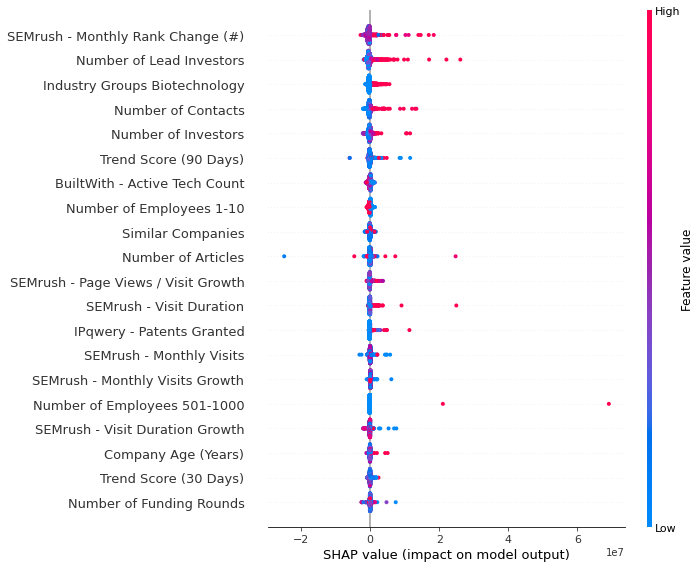

In [13]:
shap.summary_plot(train_shap_vals, shap_dataset)

---
### Bottom 100 companies by funding

In [44]:
bottom100 = dataset.sort_values('Total Funding Amount Currency (in USD)', ascending=True).drop(columns=['Total Funding Amount Currency (in USD)']).head(100)
bottom100_funding = dataset.sort_values('Total Funding Amount Currency (in USD)', ascending=True)['Total Funding Amount Currency (in USD)'].head(100)

In [38]:
bottom100_explainer = shap.TreeExplainer(gbdt)
bottom100_shap_vals = bottom100_explainer.shap_values(bottom100, check_additivity=False)

In [39]:
bottom_feat = ['SEMrush - Monthly Rank Change (#)', 'Number of Lead Investors', 'Number of Articles', 'Industry Groups Biotechnology', 'Number of Contacts',
               'Number of Investors', 'Trend Score (90 Days)', 'Number of Employees 501-1000', 'SEMrush - Page Views / Visit Growth', 'BuiltWith - Active Tech Count',
               'Number of Employees 1-10', 'Similar Companies', 'IPqwery - Patents Granted', 'Company Age (Years)', 'SEMrush - Monthly Visits Growth',
               'SEMrush - Visit Duration', 'SEMrush - Monthly Visits', 'Trend Score (30 Days)', 'Trend Score (7 Days)', 'SEMrush - Bounce Rate']
bottom_feat_dict = dict()
for feat in bottom_feat:
  bottom_feat_dict[feat] = list(bottom100.columns).index(feat)

**Bar plot**

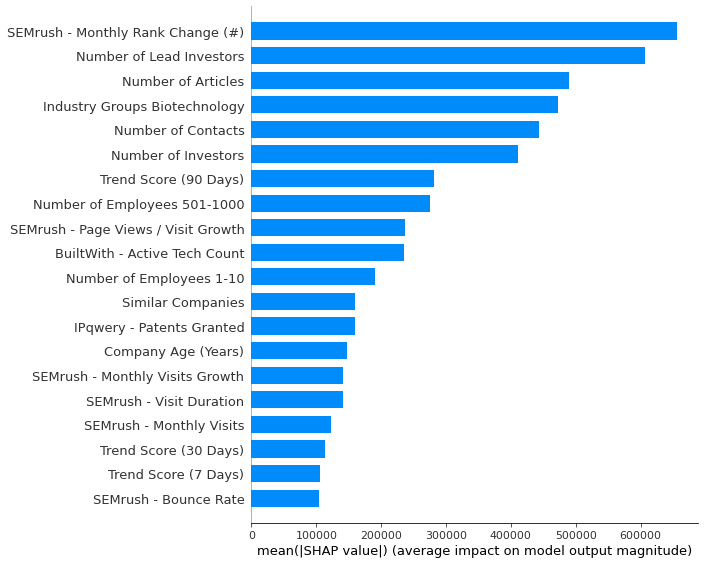

In [30]:
shap.summary_plot(bottom100_shap_vals, bottom100, plot_type='bar')

**Summary plot**

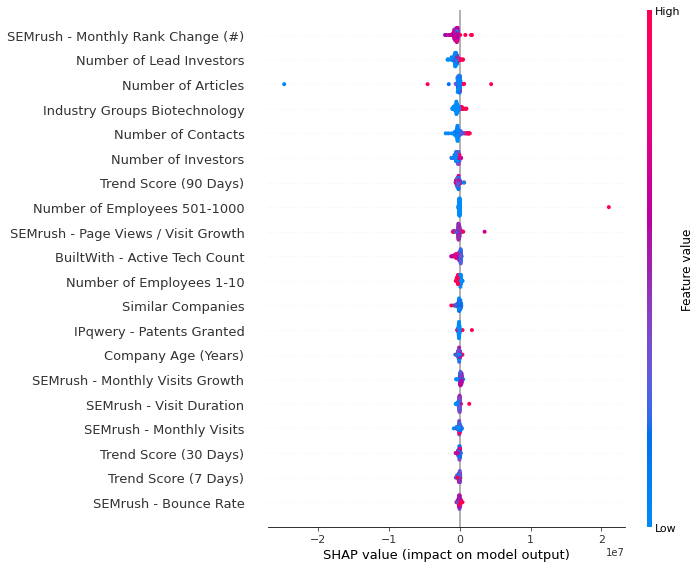

In [28]:
shap.summary_plot(bottom100_shap_vals, bottom100)

In [49]:
bottom100['Diversity Spotlight (US Only) Women Led'] = bottom100_funding
bottom100_shap_vals[:, 170] = bottom100_funding
shap_feats = list(bottom100.columns)
shap_feats[170] = 'Total Funding Amount (in USD)'

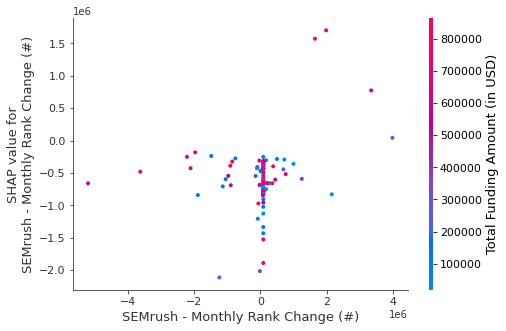

In [50]:
shap.dependence_plot(bottom_feat_dict['SEMrush - Monthly Rank Change (#)'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

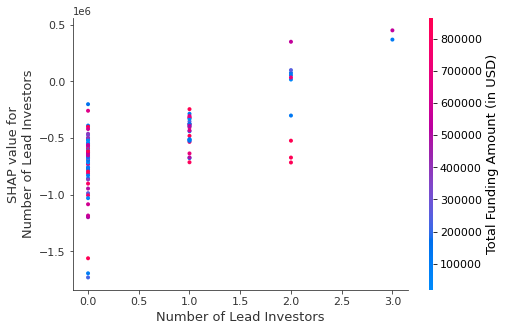

In [51]:
shap.dependence_plot(bottom_feat_dict['Number of Lead Investors'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

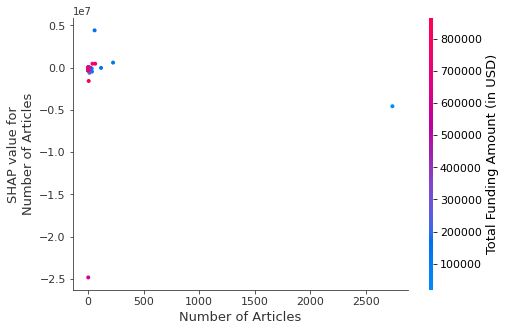

In [52]:
shap.dependence_plot(bottom_feat_dict['Number of Articles'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

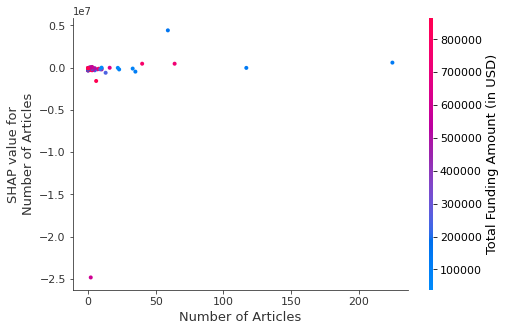

In [73]:
# Without outliers
shap.dependence_plot(bottom_feat_dict['Number of Articles'], bottom100_shap_vals[1:], bottom100.iloc[1:], feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

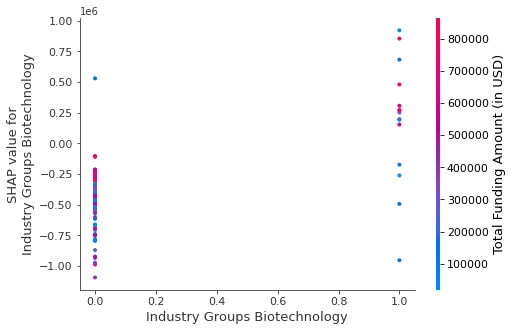

In [53]:
shap.dependence_plot(bottom_feat_dict['Industry Groups Biotechnology'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

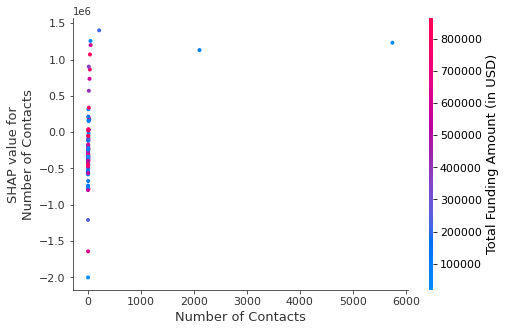

In [54]:
shap.dependence_plot(bottom_feat_dict['Number of Contacts'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

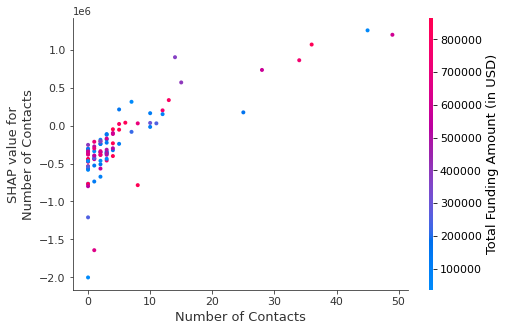

In [116]:
# Without outliers
contacts_shap_vals = bottom100_shap_vals[1:]
contacts_shap_vals = np.vstack((contacts_shap_vals[:11], contacts_shap_vals[12:]))
contacts_shap_vals = np.vstack((contacts_shap_vals[:37], contacts_shap_vals[38:]))
contacts_bottom100 = bottom100.iloc[1:]
contacts_bottom100 = contacts_bottom100.iloc[:11].append(contacts_bottom100.iloc[12:])
contacts_bottom100 = contacts_bottom100.iloc[:37].append(contacts_bottom100.iloc[38:])
shap.dependence_plot(bottom_feat_dict['Number of Contacts'], contacts_shap_vals, contacts_bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

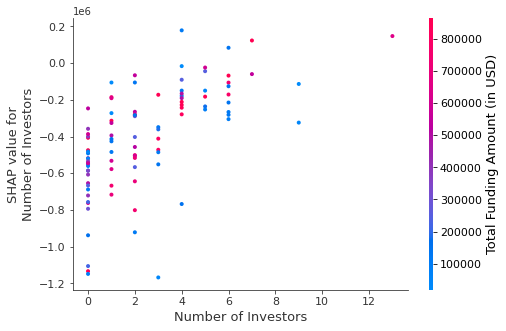

In [55]:
shap.dependence_plot(bottom_feat_dict['Number of Investors'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

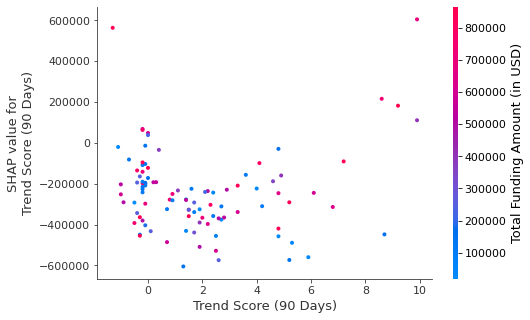

In [56]:
shap.dependence_plot(bottom_feat_dict['Trend Score (90 Days)'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

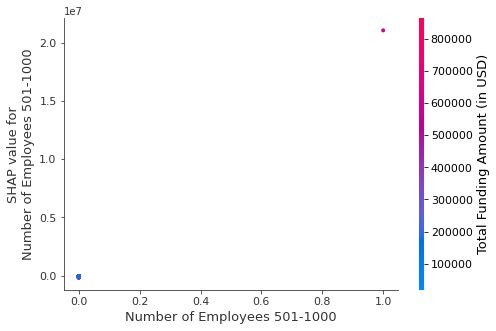

In [57]:
shap.dependence_plot(bottom_feat_dict['Number of Employees 501-1000'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

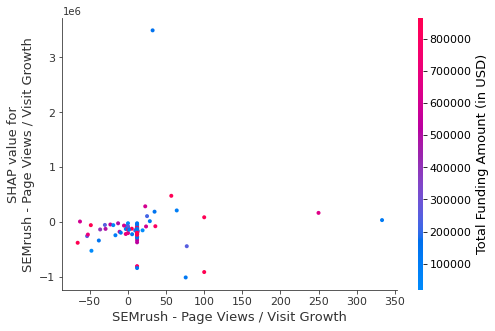

In [58]:
shap.dependence_plot(bottom_feat_dict['SEMrush - Page Views / Visit Growth'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

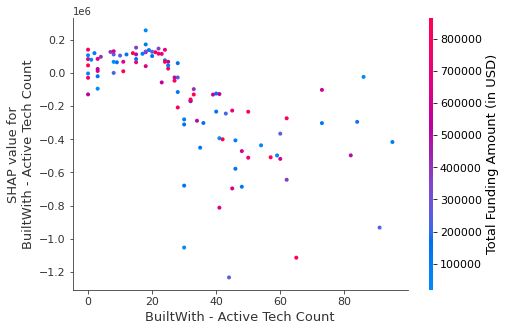

In [59]:
shap.dependence_plot(bottom_feat_dict['BuiltWith - Active Tech Count'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

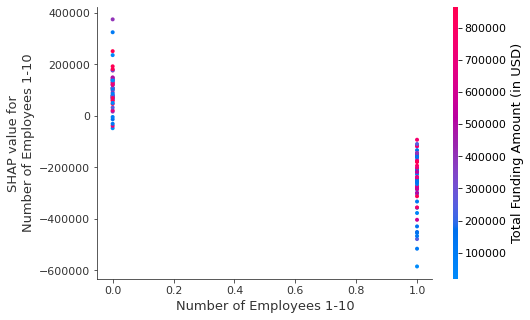

In [60]:
shap.dependence_plot(bottom_feat_dict['Number of Employees 1-10'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

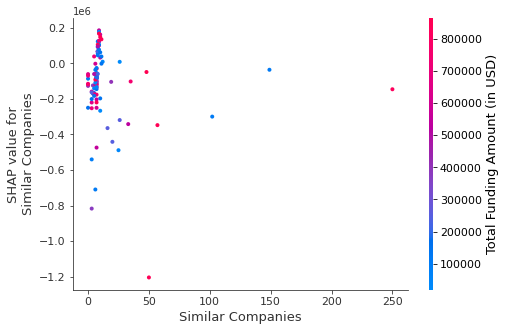

In [61]:
shap.dependence_plot(bottom_feat_dict['Similar Companies'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

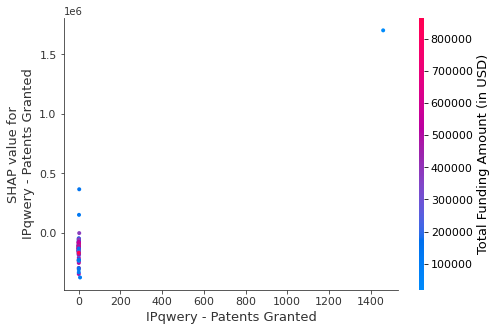

In [62]:
shap.dependence_plot(bottom_feat_dict['IPqwery - Patents Granted'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

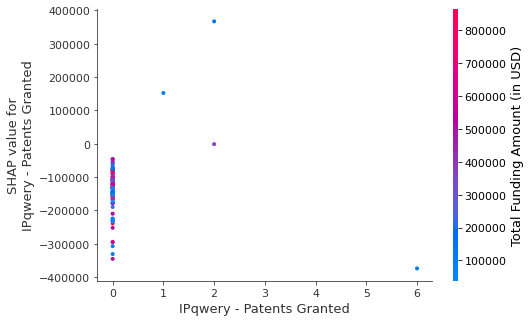

In [123]:
# Without outliers
shap.dependence_plot(bottom_feat_dict['IPqwery - Patents Granted'], bottom100_shap_vals[1:], bottom100.iloc[1:], feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

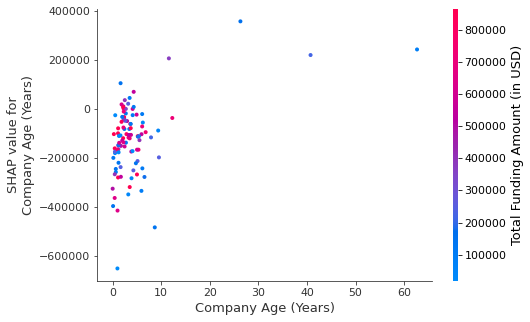

In [63]:
shap.dependence_plot(bottom_feat_dict['Company Age (Years)'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

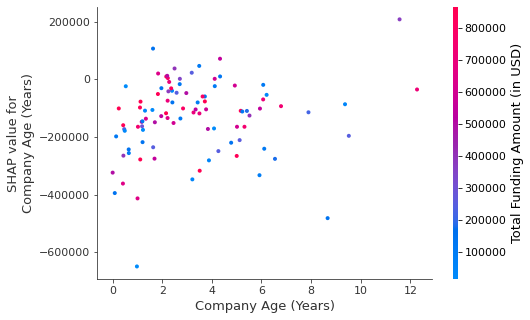

In [155]:
# Without outliers
age_shap_vals = np.vstack((bottom100_shap_vals[:12], bottom100_shap_vals[13:]))
age_shap_vals = np.vstack((age_shap_vals[:34], age_shap_vals[35:]))
age_shap_vals = np.vstack((age_shap_vals[:37], age_shap_vals[38:]))
age_bottom100 = bottom100.iloc[:12].append(bottom100.iloc[13:])
age_bottom100 = age_bottom100.iloc[:34].append(age_bottom100.iloc[35:])
age_bottom100 = age_bottom100.iloc[:37].append(age_bottom100.iloc[38:])
shap.dependence_plot(bottom_feat_dict['Company Age (Years)'], age_shap_vals, age_bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

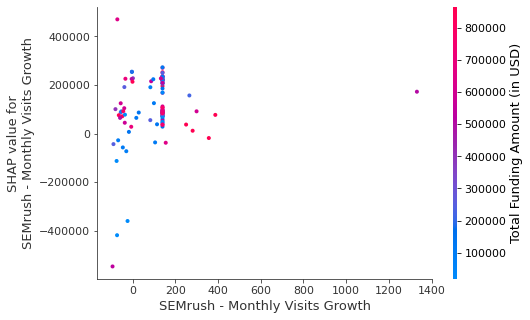

In [64]:
shap.dependence_plot(bottom_feat_dict['SEMrush - Monthly Visits Growth'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

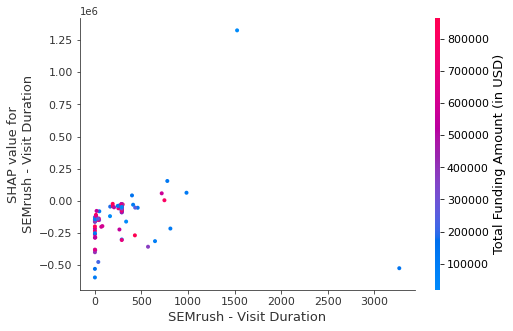

In [65]:
shap.dependence_plot(bottom_feat_dict['SEMrush - Visit Duration'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

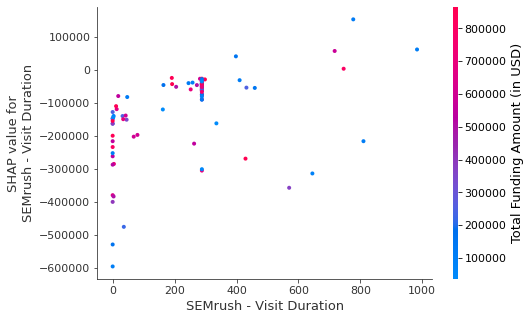

In [140]:
# Without outliers
visit_shap_vals = np.vstack((bottom100_shap_vals[:29], bottom100_shap_vals[30:]))
visit_bottom100 = bottom100.iloc[:29].append(bottom100.iloc[30:])
shap.dependence_plot(bottom_feat_dict['SEMrush - Visit Duration'], visit_shap_vals[1:], visit_bottom100.iloc[1:], feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

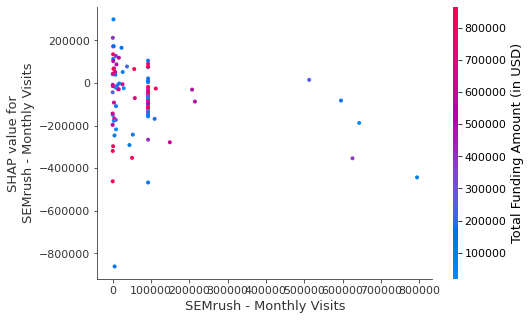

In [66]:
shap.dependence_plot(bottom_feat_dict['SEMrush - Monthly Visits'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

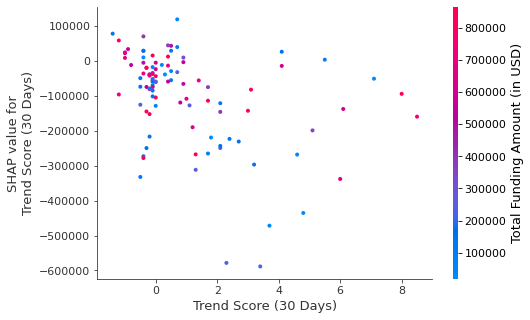

In [67]:
shap.dependence_plot(bottom_feat_dict['Trend Score (30 Days)'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

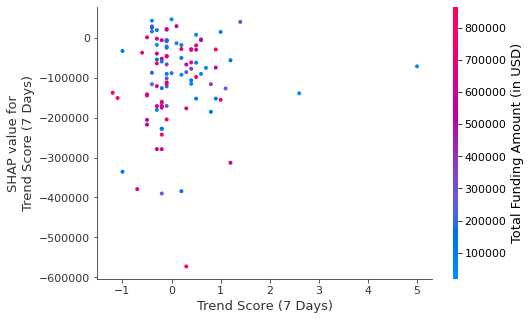

In [68]:
shap.dependence_plot(bottom_feat_dict['Trend Score (7 Days)'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

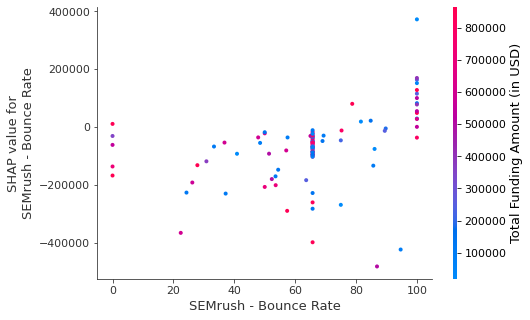

In [69]:
shap.dependence_plot(bottom_feat_dict['SEMrush - Bounce Rate'], bottom100_shap_vals, bottom100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

**Dependence and Embedding plots for top 20 features**

---
### Top 100 companies by funding

In [9]:
top100 = dataset.sort_values('Total Funding Amount Currency (in USD)', ascending=False).drop(columns=['Total Funding Amount Currency (in USD)']).head(100)
top100_funding = dataset.sort_values('Total Funding Amount Currency (in USD)', ascending=False)['Total Funding Amount Currency (in USD)'].head(100)

In [10]:
top100_explainer = shap.TreeExplainer(gbdt)
top100_shap_vals = top100_explainer.shap_values(top100, check_additivity=False)

In [11]:
top_feat = ['Number of Lead Investors', 'SEMrush - Monthly Rank Change (#)', 'Industry Groups Biotechnology', 'Number of Contacts',
            'Trend Score (90 Days)', 'Number of Investors', 'Number of Employees 501-1000', 'Number of Articles', 'SEMrush - Visit Duration', 'SEMrush - Monthly Visits',
            'IPqwery - Patents Granted', 'SEMrush - Visit Duration Growth', 'Number of Funding Rounds', 'Industry Groups Energy', 'Similar Companies', 'Number of Employees 1-10',
            'Number of Founders', 'BuiltWith - Active Tech Count', 'Trend Score (30 Days)', 'SEMrush - Page Views / Visit Growth']
top_feat_dict = dict()
for feat in top_feat:
  top_feat_dict[feat] = list(top100.columns).index(feat)

**Bar plot**

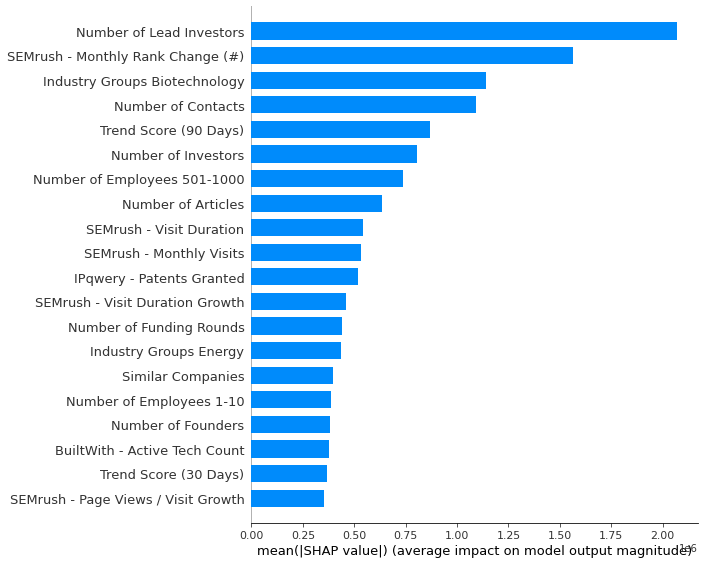

In [12]:
shap.summary_plot(top100_shap_vals, top100, plot_type='bar')

**Summary plot**

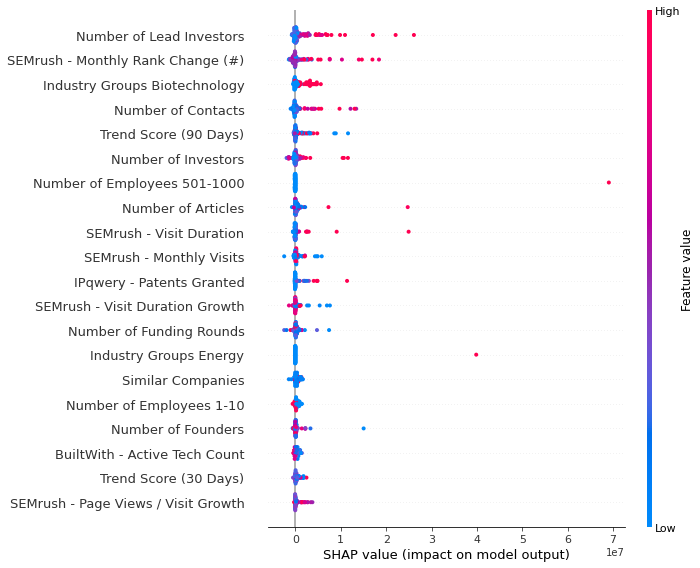

In [13]:
shap.summary_plot(top100_shap_vals, top100)

In [134]:
top100['Diversity Spotlight (US Only) Women Led'] = top100_funding
top100_shap_vals[:, 170] = top100_funding
shap_feats = list(top100.columns)
shap_feats[170] = 'Total Funding Amount (in USD)'

**Dependence and Embedding plots for top 20 features**

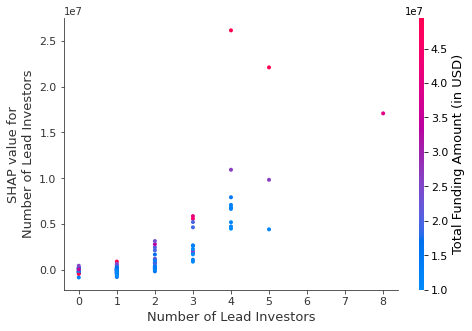

In [36]:
shap.dependence_plot(top_feat_dict['Number of Lead Investors'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

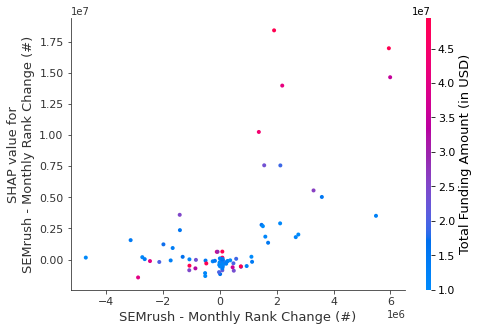

In [37]:
shap.dependence_plot(top_feat_dict['SEMrush - Monthly Rank Change (#)'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

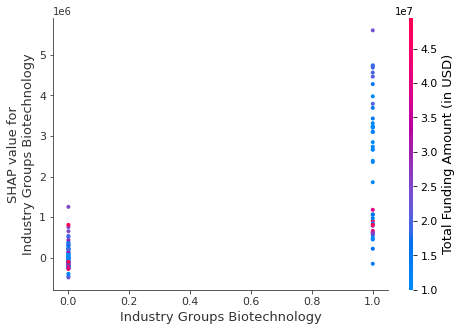

In [38]:
shap.dependence_plot(top_feat_dict['Industry Groups Biotechnology'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

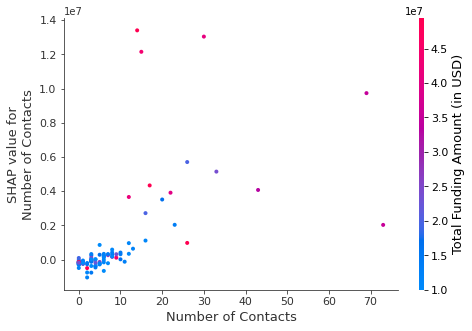

In [39]:
shap.dependence_plot(top_feat_dict['Number of Contacts'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

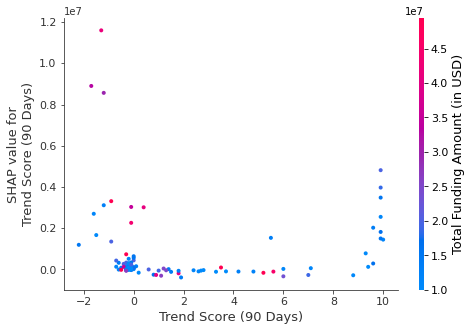

In [40]:
shap.dependence_plot(top_feat_dict['Trend Score (90 Days)'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

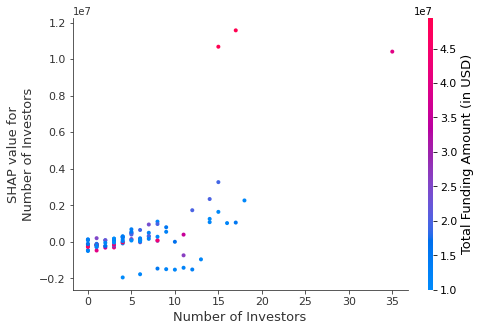

In [41]:
shap.dependence_plot(top_feat_dict['Number of Investors'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

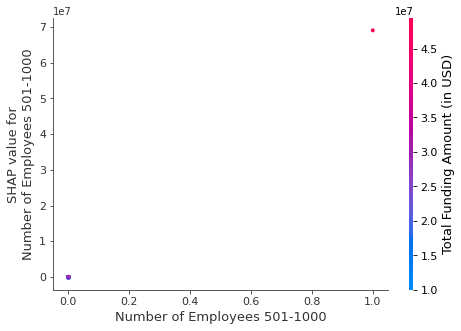

In [42]:
shap.dependence_plot(top_feat_dict['Number of Employees 501-1000'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

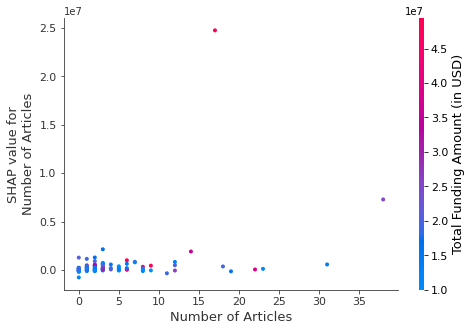

In [43]:
shap.dependence_plot(top_feat_dict['Number of Articles'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

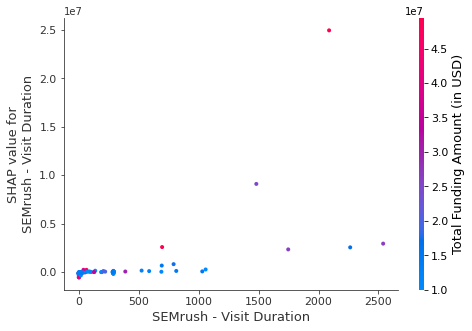

In [44]:
shap.dependence_plot(top_feat_dict['SEMrush - Visit Duration'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

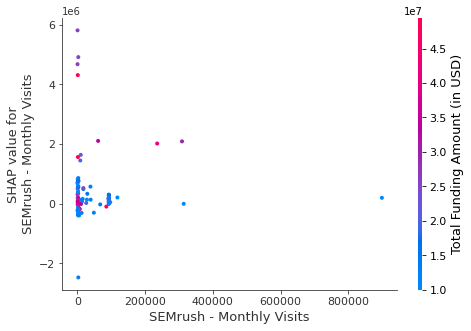

In [45]:
shap.dependence_plot(top_feat_dict['SEMrush - Monthly Visits'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

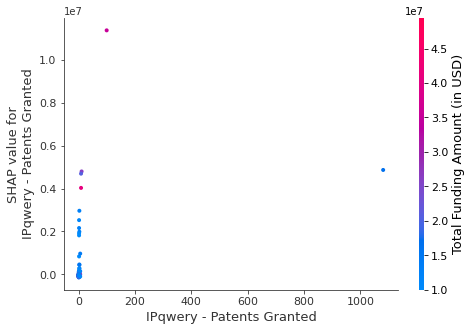

In [46]:
shap.dependence_plot(top_feat_dict['IPqwery - Patents Granted'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

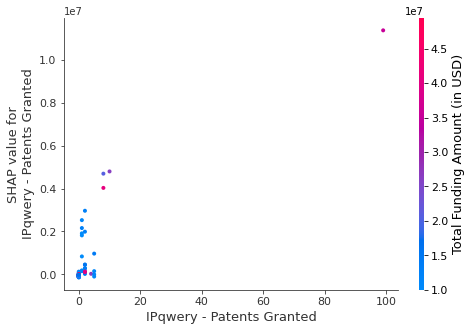

In [138]:
# Without outliers
patent_shap_vals = np.vstack((top100_shap_vals[:39], top100_shap_vals[40:]))
patent_top100 = top100.iloc[:39].append(top100.iloc[40:])
shap.dependence_plot(top_feat_dict['IPqwery - Patents Granted'], patent_shap_vals, patent_top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

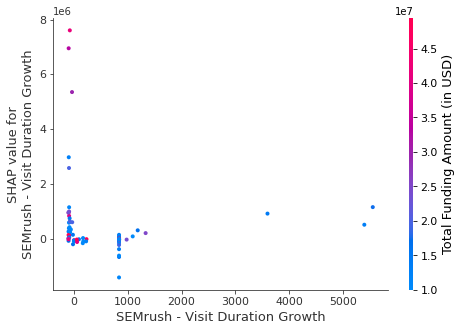

In [47]:
shap.dependence_plot(top_feat_dict['SEMrush - Visit Duration Growth'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

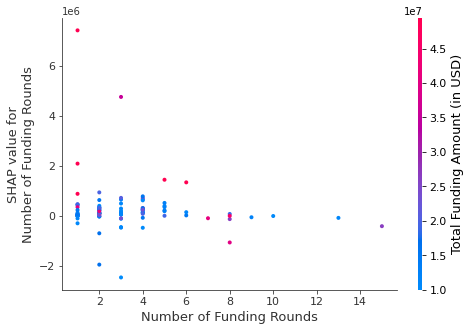

In [48]:
shap.dependence_plot(top_feat_dict['Number of Funding Rounds'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

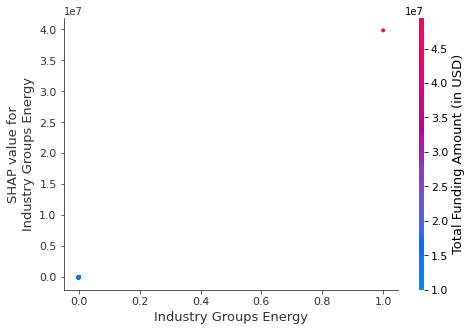

In [49]:
shap.dependence_plot(top_feat_dict['Industry Groups Energy'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

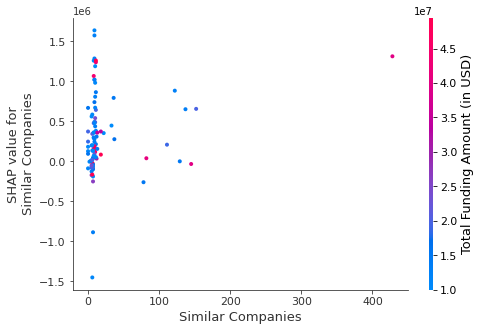

In [50]:
shap.dependence_plot(top_feat_dict['Similar Companies'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

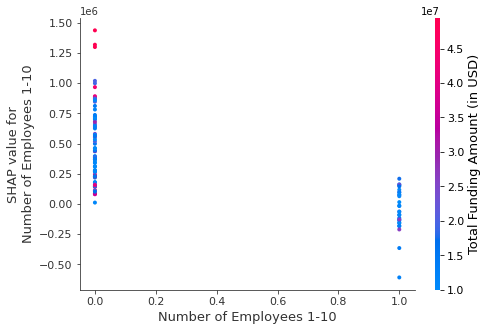

In [51]:
shap.dependence_plot(top_feat_dict['Number of Employees 1-10'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

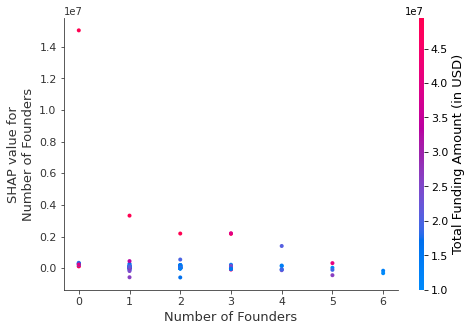

In [52]:
shap.dependence_plot(top_feat_dict['Number of Founders'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

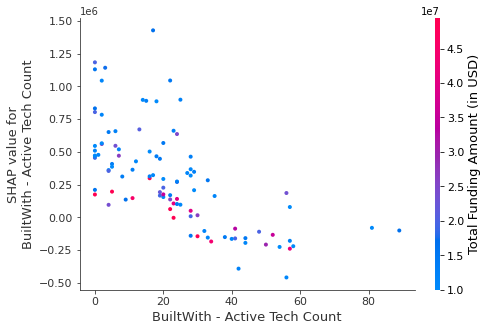

In [53]:
shap.dependence_plot(top_feat_dict['BuiltWith - Active Tech Count'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

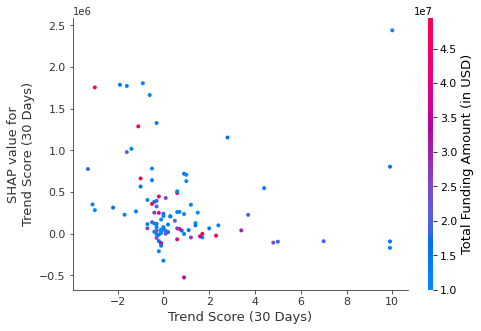

In [54]:
shap.dependence_plot(top_feat_dict['Trend Score (30 Days)'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

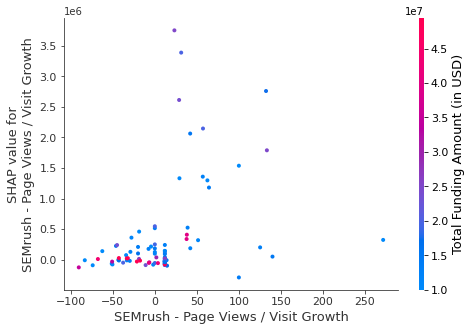

In [55]:
shap.dependence_plot(top_feat_dict['SEMrush - Page Views / Visit Growth'], top100_shap_vals, top100, feature_names=shap_feats, interaction_index='Total Funding Amount (in USD)')

## Local Model Explainability

In [15]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[0], feature_names=list(top100.columns))

In [17]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[1], feature_names=list(top100.columns))

In [18]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[2], feature_names=list(top100.columns))

In [19]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[3], feature_names=list(top100.columns))

In [20]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[4], feature_names=list(top100.columns))

In [21]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[-1], feature_names=list(top100.columns))

In [22]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[-2], feature_names=list(top100.columns))

In [23]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[-3], feature_names=list(top100.columns))

In [24]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[-4], feature_names=list(top100.columns))

In [25]:
shap.initjs()
shap.force_plot(top100_explainer.expected_value, top100_shap_vals[-5], feature_names=list(top100.columns))